# Hough Transform

In [ ]:
# Install opencv (Not neccessary, google collab has this pre-installed)
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing requisite libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from google.colab.patches import cv2_imshow

In [ ]:
# https://drive.google.com/file/d/1m_J8VbNVWku7Fwjozl9riKVkcY_1qDMh/view?usp=sharing
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1m_J8VbNVWku7Fwjozl9riKVkcY_1qDMh' -O edge.zip && unzip edge.zip

--2023-03-10 08:55:23--  https://drive.google.com/uc?export=download&id=1m_J8VbNVWku7Fwjozl9riKVkcY_1qDMh
Resolving drive.google.com (drive.google.com)... 172.253.115.100, 172.253.115.102, 172.253.115.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.115.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mecs4qho1f5ps9tl40iaqpj9s3s85e03/1678438500000/18389104903177948263/*/1m_J8VbNVWku7Fwjozl9riKVkcY_1qDMh?e=download&uuid=79030688-6d83-491c-ad28-5cd3bf0d7def [following]
--2023-03-10 08:55:25--  https://doc-0s-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mecs4qho1f5ps9tl40iaqpj9s3s85e03/1678438500000/18389104903177948263/*/1m_J8VbNVWku7Fwjozl9riKVkcY_1qDMh?e=download&uuid=79030688-6d83-491c-ad28-5cd3bf0d7def
Resolving doc-0s-0o-docs.googleusercontent.com (doc-0s-0o-docs.googleusercontent.com)... 142.251.16.132, 2

## Motivation

Once we are done with Canny Edge Detection, we get edge images like below:

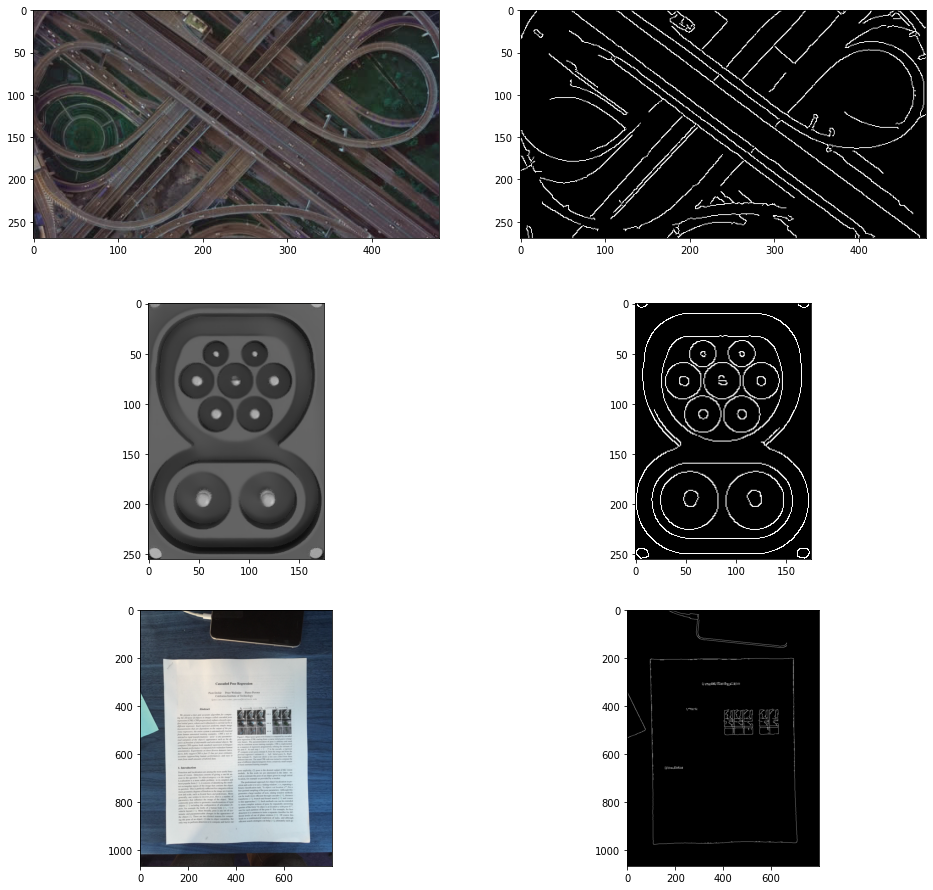

In [ ]:
# Image names
image_1 = 'RoboDiveCVImages/sample-7.jpg'
image_2 = 'RoboDiveCVImages/ccs2_plug.PNG'
image_3 = 'RoboDiveCVImages/sample-4.jpg'

image = cv2.imread(image_1)

figure = plt.figure(figsize=(16, 16))
figure.add_subplot(3, 2, 1).imshow(image)

# Converting the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blurring the image
blur_image = cv2.GaussianBlur(gray_image, (5, 5), 2)

# Appling Canny Edge Detection
edge_image = cv2.Canny(blur_image, 50, 150)
figure.add_subplot(3, 2, 2).imshow(edge_image, cmap="gray")

# For image 2
image = cv2.imread(image_2)
figure.add_subplot(3, 2, 3).imshow(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur_image = cv2.GaussianBlur(gray_image, (3, 3), 1)
edge_image = cv2.Canny(blur_image, 50, 150)
figure.add_subplot(3, 2, 4).imshow(edge_image, cmap="gray")

# For image 3
image = cv2.imread(image_3)
figure.add_subplot(3, 2, 5).imshow(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur_image = cv2.GaussianBlur(gray_image, (7, 7), 5)
edge_image = cv2.Canny(blur_image, 50, 150)
figure.add_subplot(3, 2, 6).imshow(edge_image, cmap="gray")


figure.show()

Now, we want to get some features such as circles, lines, etc from the **Edge Image** we have received after Egde Detection.

This is where Hough transform comes in.

## Hough Transform

The Hough transform is a **feature extraction technique** used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a **voting procedure**.

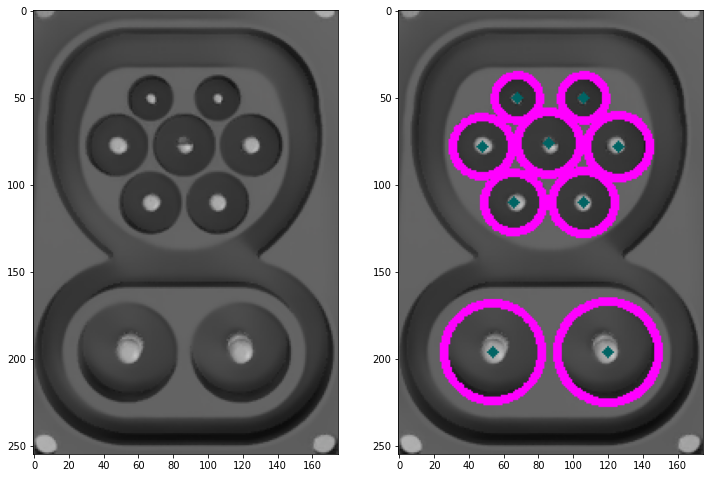

In [ ]:
image = cv2.imread("RoboDiveCVImages/ccs2_plug.PNG")
image_detected = cv2.imread("RoboDiveCVImages/ccs2_plug_circles.png")

figure = plt.figure(figsize=(12, 12))
figure.add_subplot(1, 2, 1).imshow(image)
figure.add_subplot(1, 2, 2).imshow(image_detected)
figure.show()

del image, image_detected

One of the many uses of Hough Transform lies in document scanners.
Look how dropbox uses it in it's document scanning algorithm:

https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning

## Basic Principle

The following two entites/concepts are important for this technique:

### Edge Image

Hough Transform takes in the **Edge Image** obtained from the many edge detection algorithms out there. It takes in a **Binary Image** (consisting of only 0 or 1) showing the edges in an image.

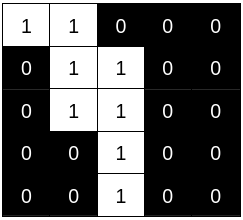


### Hough Space

We can also call this a **Parameter Space** and it alters with what we are trying to detect: lines, circles, ellipses, etc.

We will be looking at the case of lines.

We know that a line can be represented as the equation:

$y = ax + b$

So, in a cartesian plane, a two points $(x_1, y_1)$ and $(x_2, y_2)$ lying on the line would be:

$y_1 = ax_1 + b$

$y_2 = ax_2 + b$

Now, we create another plot, where $a$ and $b$ become variable, with given $(x_1, y_1)$ and $(x_2, y_2)$. In this new plot, the intersection of the two lines would give me the values of $(a, b)$.

This can be seen here:

![slope_inter_line](https://miro.medium.com/v2/resize:fit:1100/format:png/1*Y9ljU_--SdFe7on9W_axrA.png)


So, if we are given some points, and we want to find the various slope-intercept pairs of lines that pass through them, we can do this in reverse:

1. For every given $(x, y)$, plot $b = ax + y$ with $(a, b)$ as variable in the plane with $a$ on x-axis and $b$ on y-axis.

2. All the intersections give pairs of (a, b) that can then be used to plot $y = ax + b$ lines in our regular 2-D cartesian plane.

![lines_from_a_b_plane](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/hough1.gif)

---

Now, problem occurs when we have a vertical line (one going from North to South). Here, the slope (a) becomes infinity.

To overcome this, we use another **parameterisation** of the line:

$ ρ = x \cos(θ) + y \sin(θ) $

The difference here is:

1. The parameters are now $ρ$ and $θ$, so we plot them on the $ ρ-θ \space plane$.

2. The curves in the parameter space are now **sinusoids**, rather than straight lines.

However, the principle remains the same, we look for intersections in this new space to find values of $(ρ, θ)$ and plot lines using them in the cartesian plane.

![dist_angle_line](https://miro.medium.com/v2/resize:fit:1100/format:png/1*Cr73Mte5NNgO16D4moKDQg.png)

This parameter space consisting of $(ρ, θ)$ is the **Hough Parameter Space** or the **Hough Space** for lines. And the conversion from the $(x, y)$ points into curves in the **Hough Space** is the **Hough Transformation** for straight lines.

## Basic Implementation

We will use the following Edge Image:

Text(0.5, 1.0, 'Dummy Edge Image')

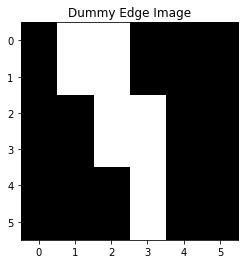

In [ ]:
# The dummy edge image
edge_image = np.array(
    [[0, 1, 1, 0, 0, 0],
     [0, 1, 1, 0, 0, 0],
     [0, 0, 1, 1, 0, 0],
     [0, 0, 1, 1, 0, 0],
     [0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0, 0]]
)

plt.imshow(edge_image, cmap="gray")
plt.title("Dummy Edge Image")

In [ ]:
# The various parameters that we can alter and test out with:
t_count = 4
num_thetas = 20
num_rhos = 20

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 2. 2. 2. 3. 2. 2. 2. 2. 0. 2. 2. 1. 0. 0. 0. 0. 0. 0.]
 [2. 2. 2. 2. 2. 1. 1. 1. 0. 0. 2. 2. 2. 2. 1. 1. 0. 0. 0. 0.]
 [4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 4. 3. 2. 2. 0. 0.]
 [4. 4. 3. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 2. 3. 4. 3. 5. 4.]
 [0. 0. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 4. 5. 4. 4.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

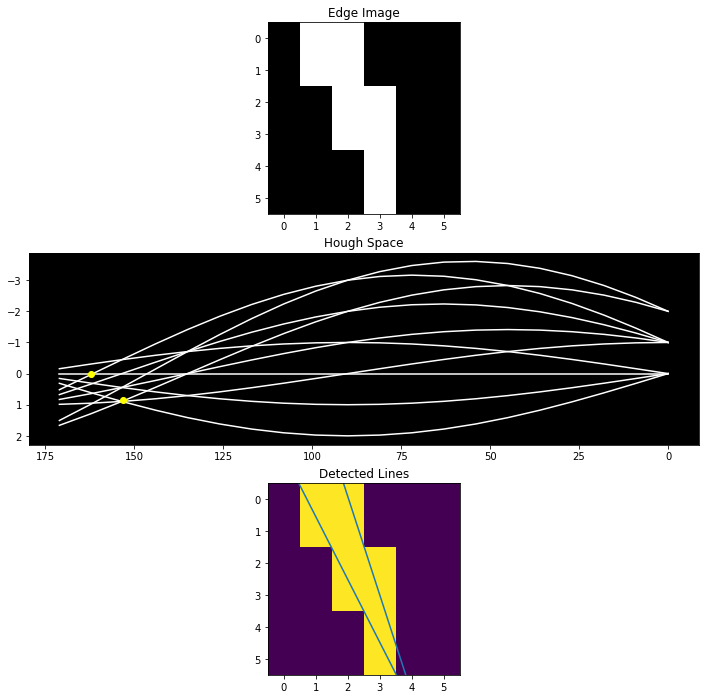

In [ ]:
# This is a basic implementation of a Hough Transform for straight lines
edge_height, edge_width = edge_image.shape[:2]
edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
#
d = np.sqrt(np.square(edge_height) + np.square(edge_width))
dtheta = 180 / num_thetas
drho = (2 * d) / num_rhos
#
thetas = np.arange(0, 180, step=dtheta)
rhos = np.arange(-d, d, step=drho)
#
cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))
#
accumulator = np.zeros((len(rhos), len(rhos)))
#
figure = plt.figure(figsize=(12, 12))
subplot2 = figure.add_subplot(3, 1, 1)
subplot2.imshow(edge_image, cmap="gray")
subplot3 = figure.add_subplot(3, 1, 2)
subplot3.set_facecolor((0, 0, 0))
subplot4 = figure.add_subplot(3, 1, 3)
subplot4.imshow(edge_image)
#
for y in range(edge_height):
    for x in range(edge_width):
        if edge_image[y][x] != 0:
            edge_point = [y - edge_height_half, x - edge_width_half]
            ys, xs = [], []
            for theta_idx in range(len(thetas)):
                rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                theta = thetas[theta_idx]
                rho_idx = np.argmin(np.abs(rhos - rho))
                accumulator[rho_idx][theta_idx] += 1
                ys.append(rho)
                xs.append(theta)
            subplot3.plot(xs, ys, color="white", alpha=1)

print(accumulator)

for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
        if accumulator[y][x] > t_count:
            rho = rhos[y]
            theta = thetas[x]
            a = np.cos(np.deg2rad(theta))
            b = np.sin(np.deg2rad(theta))
            x0 = (a * rho) + edge_width_half
            y0 = (b * rho) + edge_height_half
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            subplot3.plot([theta], [rho], marker='o', color="yellow")
            subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

subplot3.invert_yaxis()
subplot3.invert_xaxis()

subplot2.title.set_text("Edge Image")
subplot3.title.set_text("Hough Space")
subplot4.title.set_text("Detected Lines")
plt.show()

## Hough on a Real Image

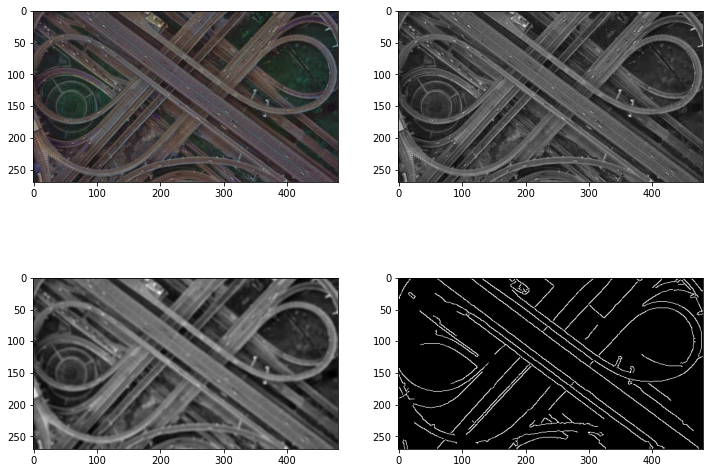

In [ ]:
image_name = 'RoboDiveCVImages/sample-7.jpg'

image = cv2.imread(image_name)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur_image = cv2.GaussianBlur(gray_image, (5, 5), 2)
edge_image = cv2.Canny(blur_image, 50, 150)

figure = plt.figure(figsize=(12, 9))

subplot1 = figure.add_subplot(2, 2, 1)
subplot1.imshow(image)
subplot2 = figure.add_subplot(2, 2, 2)
subplot2.imshow(gray_image, cmap="gray")
subplot3 = figure.add_subplot(2, 2, 3)
subplot3.imshow(blur_image, cmap="gray")
subplot4 = figure.add_subplot(2, 2, 4)
subplot4.imshow(edge_image, cmap="gray")

plt.show()

In [ ]:
def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  print(f"edge_height_half = {edge_height_half}")
  print(f"edge_width_half = {edge_width_half}")
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize = (12, 20))
  subplot1 = figure.add_subplot(4, 1, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(4, 1, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(4, 1, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(4, 1, 4)
  subplot4.imshow(image)
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)

  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas


edge_height_half = 135.0
edge_width_half = 240.0


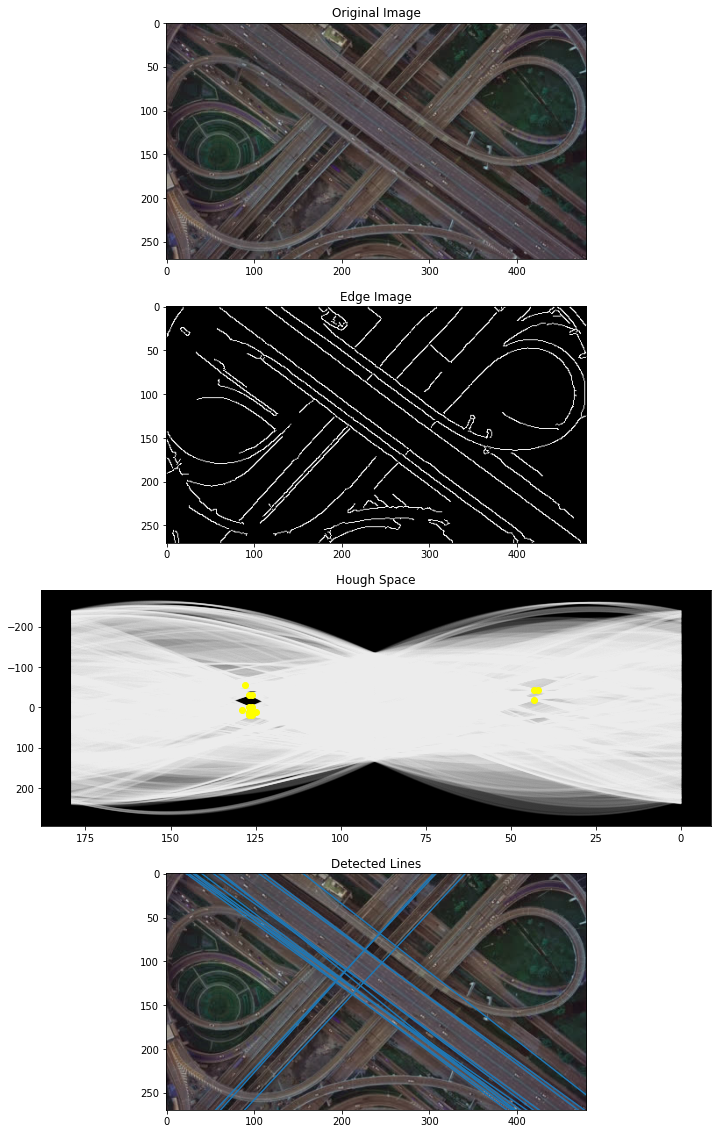

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5.50726793e+02, -5.44607606e+02, -5.38488419e+02, -5.32369233e+02,
        -5.26250046e+02, -5.20130860e+02, -5.14011673e+02, -5.07892486e+02,
        -5.01773300e+02, -4.95654113e+02, -4.89534927e+02, -4.83415740e+02,
        -4.77296554e+02, -4.71177367e+02, -4.65058180e+02, -4.58938994e+02,
        -4.52819807e+02, -4.46700621e+02, -4.40581434e+02, -4.34462247e+02,
        -4.28343061e+02, -4.22223874e+02, -4.16104688e+02, -4.09985501e+02,
        -4.03866315e+02, -3.97747128e+02, -3.91627941e+02, -3.85508755e+02,
        -3.79389568e+02, -3.73270382e+02, -3.67151195e+02, -3.61032008e+02,
        -3.54912822e+02, -3.48793635e+02, -3.42674449e+02, -3.36555262e+02,
        -3.30436076e+02, -3.24316889e+02, -3.18197702e+02, -3.12078

In [ ]:
line_detection_non_vectorized(image, edge_image, t_count = 400)

#### Reference

Much of the content has been learnt and shown from the following article. Give it a read if you are interseted to know more about this technique:

https://towardsdatascience.com/lines-detection-with-hough-transform-84020b3b1549

Another good article, which may be a *bit hard* to read through:

https://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm